## Librerias y primer vistazo a los datos


In [ ]:
import pandas as pd
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords, wordnet as wn
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy
from tqdm.auto import tqdm
from IPython.display import display
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import wordnet as wn, sentiwordnet as swn
from functools import lru_cache
from dataclasses import dataclass, field
import contractions

# Descargas NLTK necesarias (silenciosas)
try:
    nltk.download('stopwords', quiet=True)
    nltk.download('punkt', quiet=True)
    nltk.download('wordnet', quiet=True)
    nltk.download('vader_lexicon')
except Exception as e:
    print("Aviso NLTK:", e)

# Inicialización spaCy (elige modelo en/es según tus datos reales)
try:
    nlp
except NameError:
    try:
        nlp = spacy.load('en_core_web_sm', disable=['ner'])
    except Exception:
        try:
            nlp = spacy.load('es_core_news_sm', disable=['ner'])
        except Exception as e:
            print("⚠️ Falta un modelo de spaCy. Instala uno:")
            print("   python -m spacy download en_core_web_sm   (o es_core_news_sm)")
            raise

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (8,5)
print("✅ Entorno listo: imports y spaCy inicializados")


✅ Entorno listo: imports y spaCy inicializados


### Vistazo general al dataframe


In [16]:
data = pd.read_csv('dataset/df_200k.csv')
data.head()


,target,ids,date,flag,user,text
0,0,2200003196,Tue Jun 16 18:18:12 PDT 2009,NO_QUERY,LaLaLindsey0609,@chrishasboobs AHHH I HOPE YOUR OK!!!
1,0,1467998485,Mon Apr 06 23:11:14 PDT 2009,NO_QUERY,sexygrneyes,"@misstoriblack cool , i have no tweet apps fo..."
2,0,2300048954,Tue Jun 23 13:40:11 PDT 2009,NO_QUERY,sammydearr,@TiannaChaos i know just family drama. its la...
3,0,1993474027,Mon Jun 01 10:26:07 PDT 2009,NO_QUERY,Lamb_Leanne,School email won't open and I have geography ...
4,0,2256550904,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,yogicerdito,upper airways problem


In [17]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   target  200000 non-null  int64 
 1   ids     200000 non-null  int64 
 2   date    200000 non-null  object
 3   flag    200000 non-null  object
 4   user    200000 non-null  object
 5   text    200000 non-null  object
dtypes: int64(2), object(4)
memory usage: 9.2+ MB


In [18]:
data.describe()


,target,ids
count,200000.000000,2.000000e+05
mean,2.002860,1.999372e+09
std,2.000003,1.933568e+08
min,0.000000,1.467813e+09
25%,0.000000,1.957136e+09
50%,4.000000,2.002150e+09
75%,4.000000,2.177196e+09
max,4.000000,2.329205e+09


In [19]:
data.isnull().sum()


target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

In [20]:
data_clean = data[["text"]]
data_clean.head()


,text
0,@chrishasboobs AHHH I HOPE YOUR OK!!!
1,"@misstoriblack cool , i have no tweet apps fo..."
2,@TiannaChaos i know just family drama. its la...
3,School email won't open and I have geography ...
4,upper airways problem


## 1. Análisis exploratorio y preprocesamiento


### Análisis estadístico del corpus


In [21]:
# Tokenización y limpieza básica (quita URLs, menciones, puntuación básica) 
# para el análisis inicial
def clean_and_tokenize(text):
    text = str(text).lower()
    text = re.sub(r'http\S+', ' ', text)        # URLs
    text = re.sub(r'@\w+', ' ', text)           # menciones
    text = re.sub(r'#', ' ', text)              # quitar # pero mantener la palabra

    # conservar letras y números (incluye acentos)
    # quitar acentos 
    text = re.sub(r'[^0-9a-záéíóúüñ\s]', ' ', text, flags=re.IGNORECASE)
    tokens = re.findall(r'\w+', text, flags=re.UNICODE)
    return tokens


In [22]:
# Construir distribución de frecuencias de tokens
freq = Counter()
total_tokens = 0
for doc in data_clean['text'].astype(str):
    toks = clean_and_tokenize(doc)
    freq.update(toks)
    total_tokens += len(toks)

vocab = len(freq)
print(f"Tokens totales: {total_tokens:,}")
print(f"Vocabulario (tipos): {vocab:,}")


Tokens totales: 2,628,364
Vocabulario (tipos): 80,621


In [23]:
# DataFrame-like structures para análisis
words, counts = zip(*freq.most_common())
ranks = np.arange(1, len(counts) + 1)
counts_arr = np.array(counts)


### Grafico Ley de Zipf


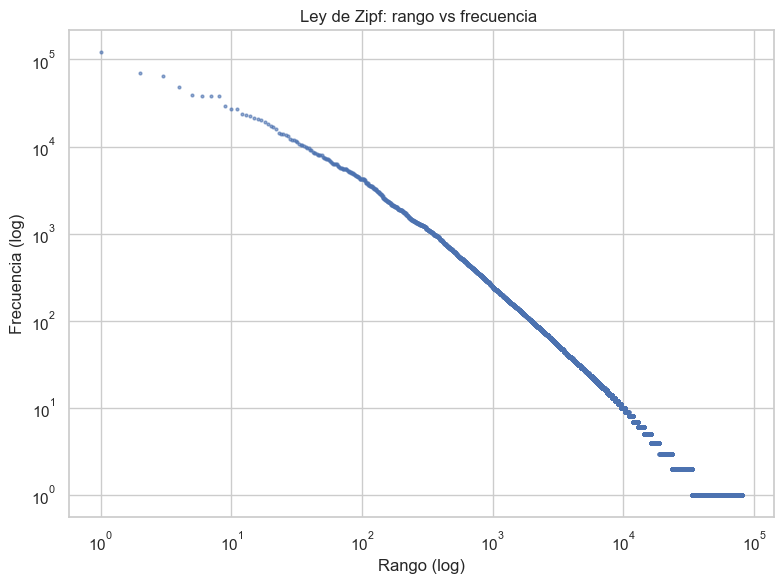

In [24]:
# Ley de Zipf: gráfico rango vs frecuencia (log-log) y ajuste lineal en log-log
plt.figure(figsize=(8,6))
plt.scatter(ranks[:], counts_arr[:], s=4, alpha=0.6)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Rango (log)')
plt.ylabel('Frecuencia (log)')
plt.title('Ley de Zipf: rango vs frecuencia ')
plt.tight_layout()
plt.show()


Ajuste log-log (primeros 2000): slope = -1.1794, intercept = 13.6560
Interpretación: frecuencia ~ C * rank^{slope} (esperado ~ -1 para Zipf clásico)


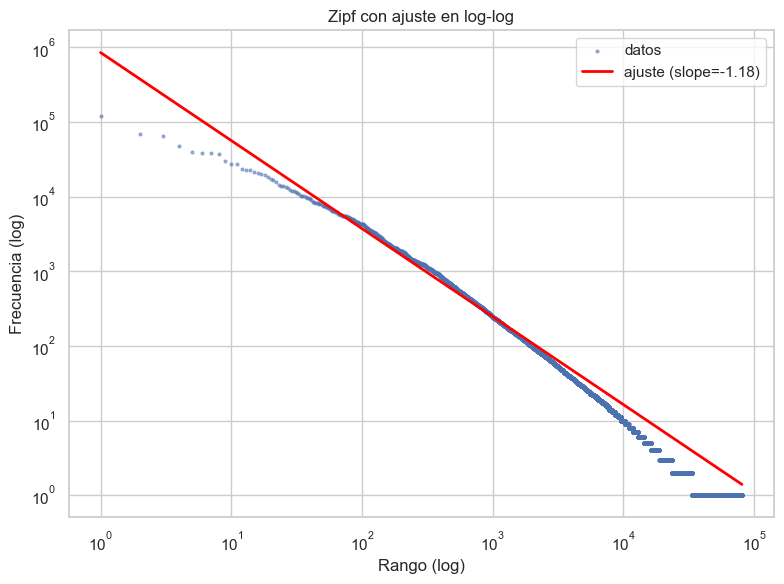

In [25]:
# Ajuste lineal en log-log para los primeros K ranks (p. ej. 1..2000)
K = min(2000, len(counts_arr))
log_r = np.log(ranks[:K])
log_f = np.log(counts_arr[:K])
slope, intercept = np.polyfit(log_r, log_f, 1)
print(f"Ajuste log-log (primeros {K}): slope = {slope:.4f}, intercept = {intercept:.4f}")
print("Interpretación: frecuencia ~ C * rank^{slope} (esperado ~ -1 para Zipf clásico)")

# Dibujar la línea ajustada sobre el scatter 
pred_logf = intercept + slope * np.log(ranks[:])
pred_f = np.exp(pred_logf)
plt.figure(figsize=(8,6))
plt.scatter(ranks[:], counts_arr[:], s=4, alpha=0.5, label='datos')
plt.plot(ranks[:], pred_f, color='red', lw=2, label=f'ajuste (slope={slope:.2f})')
plt.xscale('log'); plt.yscale('log')
plt.xlabel('Rango (log)')
plt.ylabel('Frecuencia (log)')
plt.title('Zipf con ajuste en log-log')
plt.legend()
plt.tight_layout()
plt.show()


### Grafico distribuciones


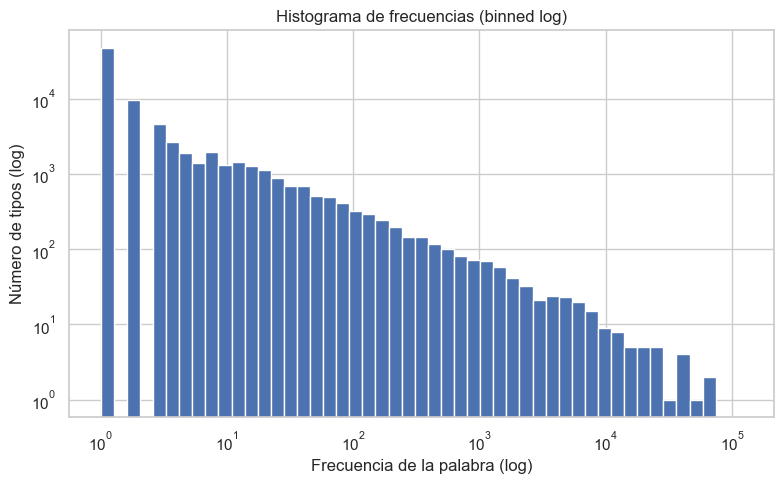

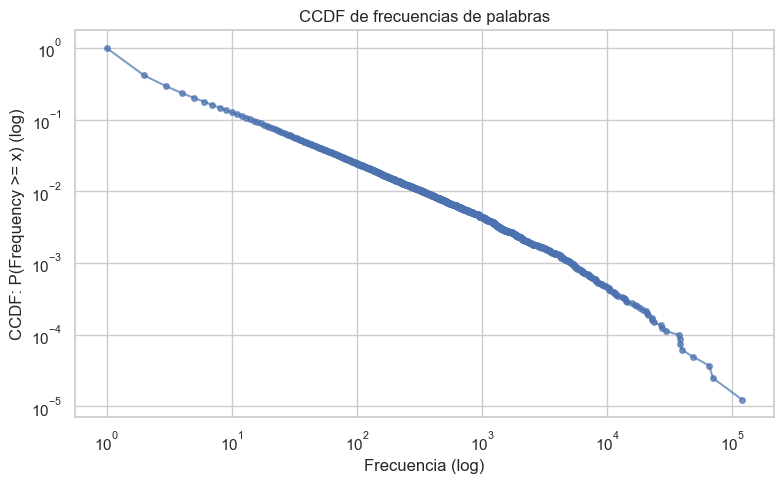

In [26]:
# Distribución de frecuencias: histograma (log-binned) y CCDF
# Histograma con ejes log
plt.figure(figsize=(8,5))
plt.hist(counts_arr, bins=np.logspace(np.log10(1), np.log10(counts_arr.max()), 50))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frecuencia de la palabra (log)')
plt.ylabel('Número de tipos (log)')
plt.title('Histograma de frecuencias (binned log)')
plt.tight_layout()
plt.show()

# CCDF: proporción de tipos con frecuencia >= x
sorted_counts = np.sort(counts_arr)
unique_vals, counts_of_vals = np.unique(sorted_counts, return_counts=True)
ccdf_vals = np.cumsum(counts_of_vals[::-1])[::-1] / vocab  # proporción de tipos >= val
plt.figure(figsize=(8,5))
plt.loglog(unique_vals, ccdf_vals, marker='o', ms=4, alpha=0.7)
plt.xlabel('Frecuencia (log)')
plt.ylabel('CCDF: P(Frequency >= x) (log)')
plt.title('CCDF de frecuencias de palabras')
plt.tight_layout()
plt.show()


## Pipeline de limpieza específico para tweets


In [27]:
# Stopwords en inglés
stop_words = set(stopwords.words('english'))

# Limpieza de URLs y menciones
URL_PATTERN = r"http\S+|www\.\S+"
MENTION_PATTERN = r"@\w+"

# Sustituimos cualquier cosa no alfabética por espacio (dejamos espacios)
NON_ALPHA_PATTERN = r"[^a-z\s]"
EMOJI_PATTERN = r"[\U00010000-\U0010ffff]"  # rango Unicode emojis y pictos

def preprocess_review(text: str, nlp, stop_words) -> list:
    """
    Limpieza específica para tweets EN:
      1) lower + expansión de contracciones (don't->do not)
      2) quita URLs, menciones y caracteres no alfabéticos
      3) normaliza números a <NUM> y emojis a <EMOJI>
      4) lematiza con spaCy (en)
      5) filtra stopwords y tokens cortos
    Devuelve: lista de tokens lematizados limpios
    """
    # 1) lower + contracciones
    text = text if isinstance(text, str) else str(text)
    text = text.lower()
    text = contractions.fix(text)  # "can't" -> "cannot"

    # 2) ruido típico de tweets
    text = re.sub(URL_PATTERN, " ", text)
    text = re.sub(MENTION_PATTERN, " ", text)
    # Números y emojis se mapean a tags para no perder la señal semántica
    text = re.sub(r"\d+", " <NUM> ", text)
    text = re.sub(EMOJI_PATTERN, " <EMOJI> ", text)
    # El resto de signos no alfabéticos fuera
    text = re.sub(NON_ALPHA_PATTERN, " ", text)
    text = re.sub(r"\s+", " ", text).strip()

    # 3) Lematización spaCy
    #   Nota: spaCy tokeniza y da lemma por token; aquí ignoramos signos ya filtrados
    doc = nlp(text)
    lemmas = [t.lemma_ for t in doc]

    # 4) Filtrado final: stopwords + longitud mínima
    clean_lemmas = [w for w in lemmas if w not in stop_words and len(w) > 2]

    return clean_lemmas


In [28]:
# Pasar de data_clean a df para mayor comodidad
df = data_clean.copy()

# Aplica el pipeline completo (tokens + lemas limpios)
df['lemmas'] = df['text'].astype(str).apply(lambda s: preprocess_review(s, nlp, stop_words))

# Texto limpio “join” (útil para TF-IDF, WordCloud, etc.)
df['clean_text'] = df['lemmas'].apply(lambda xs: " ".join(xs))

print(f" Procesadas {len(df)} tweets. Columnas añadidas: 'lemmas', 'tokens', 'clean_text'")
df.head(3)


 Procesadas 200000 tweets. Columnas añadidas: 'lemmas', 'tokens', 'clean_text'


,text,lemmas,clean_text
0,@chrishasboobs AHHH I HOPE YOUR OK!!!,"[ahhh, hope]",ahhh hope
1,"@misstoriblack cool , i have no tweet apps fo...","[cool, tweet, app, razr]",cool tweet app razr
2,@TiannaChaos i know just family drama. its la...,"[know, family, drama, lame, hey, next, time, h...",know family drama lame hey next time hang kim ...


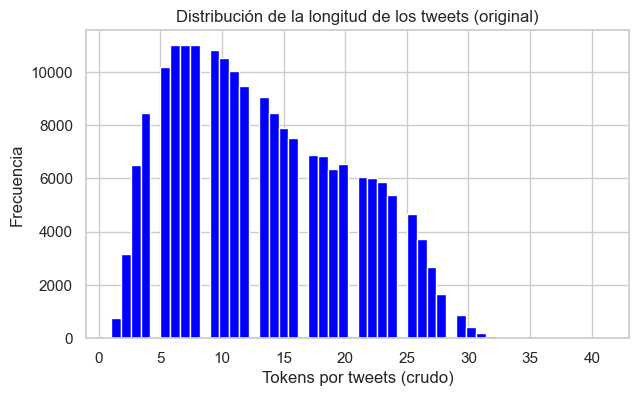

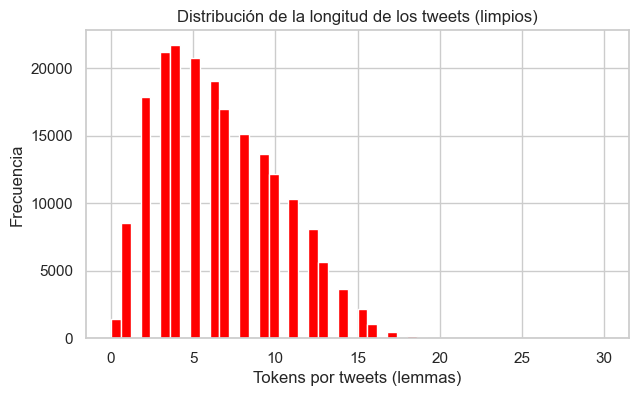

 Media longitud cruda: 13.19 | Media longitud limpia: 6.47


In [29]:
# Longitud cruda por tweets (número de palabras)
len_raw = df['text'].astype(str).apply(lambda s: len(s.split()))

# Longitud tras limpieza (número de lemas por tweets)
len_clean = df['lemmas'].apply(len)

# Histograma antes y después de limpieza
plt.figure(figsize=(7,4))
plt.hist(len_raw, bins=50, color='blue')
plt.title("Distribución de la longitud de los tweets (original)")
plt.xlabel("Tokens por tweets (crudo)")
plt.ylabel("Frecuencia")
plt.show()

plt.figure(figsize=(7,4))
plt.hist(len_clean, bins=50, color='red')
plt.title("Distribución de la longitud de los tweets (limpios)")
plt.xlabel("Tokens por tweets (lemmas)")
plt.ylabel("Frecuencia")
plt.show()

print(f" Media longitud cruda: {len_raw.mean():.2f} | Media longitud limpia: {len_clean.mean():.2f}")


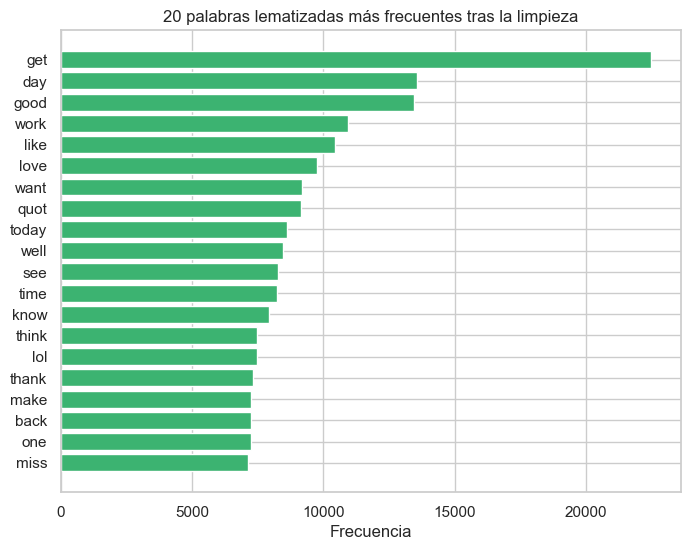

In [30]:
# Aplana la lista de lemas
flat_lemmas = [w for toks in df['lemmas'] for w in toks]
top20 = Counter(flat_lemmas).most_common(20)

# Mostrar el top-20
words, freqs = zip(*top20)
plt.figure(figsize=(8,6))
plt.barh(words, freqs, color='mediumseagreen')
plt.gca().invert_yaxis()
plt.title("20 palabras lematizadas más frecuentes tras la limpieza")
plt.xlabel("Frecuencia")
plt.show()


## Identificación de patrones sintácticos relevantes


C:\Users\javie\AppData\Local\Temp\ipykernel_22516\2045220747.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pos_df, y='POS', x='Frecuencia', palette='crest')


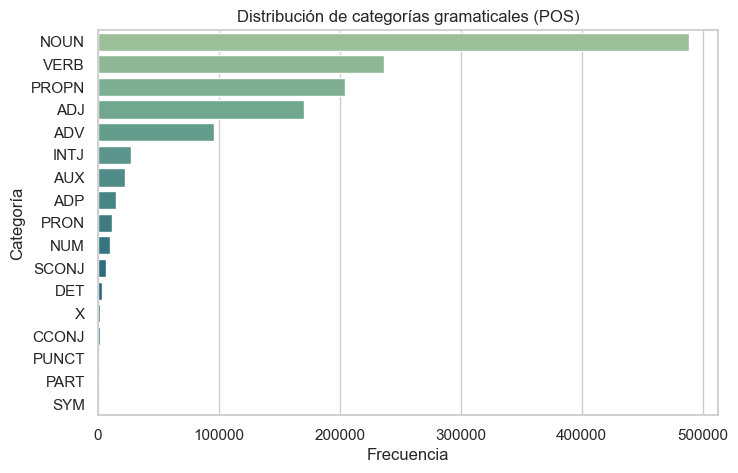

C:\Users\javie\AppData\Local\Temp\ipykernel_22516\2045220747.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=adj_df, y='Adjetivo', x='Frecuencia', palette='magma')


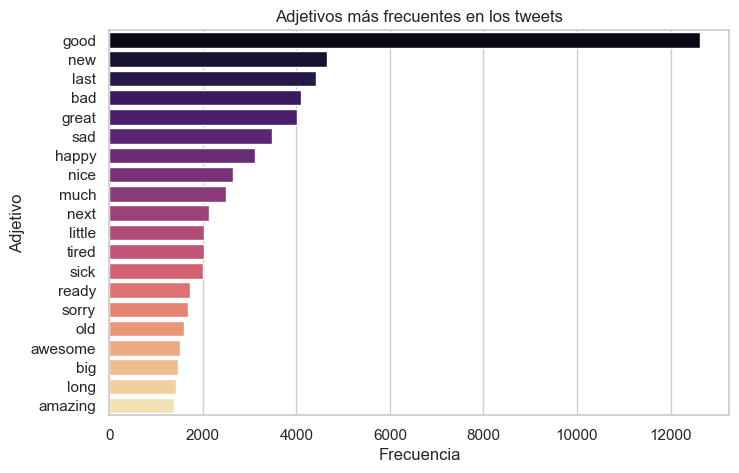

,Adjetivo,Frecuencia
0,good,12626
1,new,4656
2,last,4421
3,bad,4092
4,great,4021
5,sad,3484
6,happy,3108
7,nice,2637
8,much,2487
9,next,2141


In [31]:
# Tomamos una muestra del corpus para análisis sintáctico
sample_texts = df['clean_text'].tolist()

# Analizamos con spaCy
docs = list(nlp.pipe(sample_texts, disable=['ner']))

# 1️ Distribución de etiquetas gramaticales (POS)
pos_counts = Counter([token.pos_ for doc in docs for token in doc])
pos_df = pd.DataFrame(pos_counts.most_common(), columns=['POS', 'Frecuencia'])

plt.figure(figsize=(8,5))
sns.barplot(data=pos_df, y='POS', x='Frecuencia', palette='crest')
plt.title("Distribución de categorías gramaticales (POS)")
plt.xlabel("Frecuencia")
plt.ylabel("Categoría")
plt.show()

# 2️ Adjetivos más frecuentes (indicadores de opinión)
adj_counts = Counter([token.lemma_ for doc in docs for token in doc if token.pos_ == 'ADJ'])
adj_df = pd.DataFrame(adj_counts.most_common(20), columns=['Adjetivo', 'Frecuencia'])

plt.figure(figsize=(8,5))
sns.barplot(data=adj_df, y='Adjetivo', x='Frecuencia', palette='magma')
plt.title("Adjetivos más frecuentes en los tweets")
plt.xlabel("Frecuencia")
plt.ylabel("Adjetivo")
plt.show()

display(adj_df.head(10))


In [51]:
## 3. Configuración, léxicos y utilidades

PALABRAS_POSITIVAS = {
    'good','great','awesome','excellent','amazing','wonderful','fantastic',
    'love','loved','loving','best','better','perfect','nice','beautiful',
    'happy','glad','joy','joyful','pleased','delighted','enjoy','enjoyed',
    'like','liked','favorite','brilliant','outstanding','superb','impressive',
    'positive','success','successful','win','winner','winning','recommend',
    'fun','interesting','cool','sweet','thanks','thank','appreciate',
    'worthy','worth','quality','helpful','easy','comfortable','pretty',
    'gorgeous','adorable','cute','charm','charming','pleasant','satisfied','awesome'
}

PALABRAS_NEGATIVAS = {
    'bad','terrible','awful','horrible','worst','worse','poor','hate',
    'hated','dislike','disappointing','disappointed','disappointment',
    'sad','angry','upset','annoying','annoyed','frustrating','frustrated',
    'boring','bored','dull','useless','waste','wasted','fail','failed',
    'failure','problem','issue','trouble','difficult','hard','sucks',
    'stupid','dumb','ugly','disgusting','nasty','gross','crap','shit',
    'damn','hell','wrong','error','broken','broke','uncomfortable',
    'painful','pain','suffer','suffering','regret','sorry','weak','scam','buggy'
}

NEGACIONES = {
    'not','no',"n't",'never','neither','nobody','nothing','nowhere',
    'none','nor','cannot','cant',"can't","won't","wouldn't","shouldn't",
    "couldn't","doesn't","don't","didn't","isn't","aren't","wasn't","weren't"
}

INTENSIFICADORES = {
    'very':1.5,'really':1.5,'extremely':2.0,'absolutely':1.8,
    'incredibly':1.8,'highly':1.5,'particularly':1.3,'especially':1.3,
    'totally':1.6,'completely':1.6,'utterly':1.7,'quite':1.2,
    'so':1.4,'too':1.3,'super':1.5,'exceptionally':1.8
}

ATENUADORES = {
    'somewhat':0.5,'slightly':0.5,'barely':0.4,'hardly':0.4,
    'almost':0.6,'nearly':0.6,'kind':0.5,'sort':0.5,
    'little':0.6,'bit':0.6,'rather':0.7,'fairly':0.7
}

# Emoticonos (NO emojis). Contribuyen como pequeño boost de polaridad.
EMOTICON_SENT = {
    ":)": 0.6, ":-)": 0.6, ":D": 0.9, ":-D": 0.9, ";)": 0.4,
    ":(": -0.6, ":-(": -0.6, ":'(": -0.9, ">:(": -1.1, "XD": 0.7
}

PIVOTES_CONTRASTE = {"but","however","though","although"}

@dataclass
class Config:
    usar_sentiwordnet: bool = True
    ventana_negacion: int = 3
    reset_negacion_en_puntuacion: bool = True
    boost_exclamacion: float = 0.10
    boost_repeticion: float = 0.10
    peso_pre_contraste: float = 0.5
    peso_post_contraste: float = 1.5
    max_stack_mod: int = 2
    limites_puntuacion_reset: set = field(default_factory=lambda: {".","!","?",";","—","-","…"})
    pos: set = field(default_factory=lambda: set(PALABRAS_POSITIVAS))
    neg: set = field(default_factory=lambda: set(PALABRAS_NEGATIVAS))
    negaciones: set = field(default_factory=lambda: set(NEGACIONES))
    intensificadores: dict = field(default_factory=lambda: dict(INTENSIFICADORES))
    atenuadores: dict = field(default_factory=lambda: dict(ATENUADORES))

CFG = Config()
print("✓ Config preparada")


✓ Config preparada


## Utilidades específicas de sentimiento (SentiWordNet, contadores)


In [52]:
def senti_from_swn(lemma: str, wn_pos) -> float:
    try:
        synsets = list(swn.senti_synsets(lemma, pos=wn_pos))
        if not synsets:
            return 0.0
        best = max(synsets, key=lambda ss: abs(ss.pos_score() - ss.neg_score()))
        return best.pos_score() - best.neg_score()
    except Exception:
        return 0.0

def contar_exclamaciones(texto: str) -> int:
    return texto.count('!')

def pos_tag_tokens(tokens):
    if not tokens:
        return []

    # Construimos un doc con los lemmas ya limpios
    doc = nlp(" ".join(tokens))

    # Recogemos solo tokens "reales" (sin espacios)
    spacy_pos = [t.pos_ for t in doc if not t.is_space]

    # Empareja longitudes (por si spaCy tokeniza algo distinto)
    L = min(len(tokens), len(spacy_pos))
    return [(tokens[i], spacy_pos[i]) for i in range(L)]


In [53]:
## 7. Motor de análisis basado en reglas (mejorado)

PIVOTES_CONTRASTE = {"but","however","though","although"}

def _aplicar_modificador(score_word: float, modificador: float, negacion_activa: bool) -> float:
    v = score_word * modificador
    return -v if negacion_activa else v

def normalizar_emoticonos(texto: str) -> float:
    total = 0.0
    for emo, val in EMOTICON_SENT.items():
        total += texto.count(emo) * val
    return total

def _segmentos_contraste(tokens):
    for i, tok in enumerate(tokens):
        if tok in PIVOTES_CONTRASTE:
            return tokens[:i], tokens[i+1:]
    return tokens, []

def _to_wn_pos(tag: str):
    if tag.startswith('J'):
        return wn.ADJ
    if tag.startswith('V'):
        return wn.VERB
    if tag.startswith('N'):
        return wn.NOUN
    if tag.startswith('R'):
        return wn.ADV
    return wn.NOUN



REPEAT_CHAR_RE = re.compile(r'([a-zA-Z])\1{2,}')
def contar_repeticiones_letras(texto: str) -> int:
    return len(REPEAT_CHAR_RE.findall(texto))

def analizar_sentimiento_texto(texto: str, cfg: Config = CFG) -> float:

    if not texto:
        return 0.0

    # 1) Boost por emoticonos en el texto ORIGINAL (no preprocesado)
    boost_emoticon = normalizar_emoticonos(texto)

    # 2) Preprocesamiento NUEVO -> lemmas
    tokens = preprocess_review(texto, nlp, stop_words)
    if not tokens:
        return boost_emoticon

    # 3) Segmentos de contraste
    left, right = _segmentos_contraste(tokens)

    def puntuar_bloque(btokens):
        score = 0.0
        if not btokens:
            return score

        # Etiquetado POS (usa tu función utilitaria existente)
        tagged = pos_tag_tokens(btokens)

        negacion_activa = False
        ventana = 0
        stack_mod = 0
        modificador = 1.0

        for i, (tok, pos) in enumerate(tagged):
            # Reset por puntuación
            if cfg.reset_negacion_en_puntuacion and tok in cfg.limites_puntuacion_reset:
                negacion_activa = False
                ventana = 0
                modificador = 1.0
                stack_mod = 0
                continue

            # Ventana de negación
            if negacion_activa:
                ventana += 1
                if ventana > cfg.ventana_negacion:
                    negacion_activa = False
                    ventana = 0

            # Negaciones
            if tok in cfg.negaciones:
                negacion_activa = True
                ventana = 0
                continue

            # Intensificadores / Atenuadores
            if tok in cfg.intensificadores:
                modificador *= cfg.intensificadores[tok]
                stack_mod += 1
                if stack_mod > cfg.max_stack_mod:
                    modificador = max(modificador, cfg.intensificadores[tok])
                continue

            if tok in cfg.atenuadores:
                modificador *= cfg.atenuadores[tok]
                stack_mod += 1
                if stack_mod > cfg.max_stack_mod:
                    modificador = min(modificador, cfg.atenuadores[tok])
                continue

            # 4) Puntuación por lexicón/SWN
            s = 0.0
            if tok in cfg.pos:
                s = 1.0
            elif tok in cfg.neg:
                s = -1.0
            elif cfg.usar_sentiwordnet:
                wn_pos = _to_wn_pos(pos)
                lemma = tok  # YA está lematizado por preprocess_review
                s = senti_from_swn(lemma, wn_pos)

            if s != 0.0:
                score += _aplicar_modificador(s, modificador, negacion_activa)
                modificador = 1.0
                stack_mod = 0

        return score

    score_left = puntuar_bloque(left)
    score_right = puntuar_bloque(right)
    score = (CFG.peso_pre_contraste * score_left + CFG.peso_post_contraste * score_right) if right else score_left

    # 5) Paralingüísticos sobre el texto original
    excls = contar_exclamaciones(texto)
    reps = contar_repeticiones_letras(texto)
    if excls > 0:
        score *= (1 + CFG.boost_exclamacion * excls)
    if reps > 0:
        score *= (1 + CFG.boost_repeticion * reps)

    # 6) Sumar boost de emoticonos
    score += boost_emoticon
    return score

# Pruebas rápidas
ejemplos = [
    "This is amazing! I love it! :)",
    "This is terrible. I hate it :(",
    "Not bad, quite good actually.",
    "This is not good at all.",
    "BEST MOVIE EVER!!!",
    "I wanted to like it, but it was boring...",
    "Great camera, however the battery is awful :(",
    "soooo goooood!!!",
    "I can't say it's bad",
]
for e in ejemplos:
    print(e, "->", round(analizar_sentimiento_texto(e), 3))



This is amazing! I love it! :) -> 3.0
This is terrible. I hate it :( -> -2.6
Not bad, quite good actually. -> 0.2
This is not good at all. -> 1.0
BEST MOVIE EVER!!! -> 1.3
I wanted to like it, but it was boring... -> -0.625
Great camera, however the battery is awful :( -> -1.975
soooo goooood!!! -> 0.0
I can't say it's bad -> -0.875


In [59]:
## 8. VADER como referencia (silver labels) y utilidades

VADER = SentimentIntensityAnalyzer()

def vader_label(texto: str, pos_th=0.05, neg_th=-0.05):
    """Devuelve 4 (pos), 0 (neg) o None (neutral) según compound de VADER."""
    if texto is None or (isinstance(texto, float) and np.isnan(texto)):
        return None
    s = VADER.polarity_scores(str(texto))
    c = s["compound"]
    if c > pos_th: return 4
    if c < neg_th: return 0
    return None  # neutro

def vader_compound(texto: str):
    if texto is None or (isinstance(texto, float) and np.isnan(texto)):
        return 0.0
    return VADER.polarity_scores(str(texto))["compound"]

print("✓ VADER listo")


✓ VADER listo


In [60]:
## 11. Calibración de umbral contra VADER (muestra, descartando neutros)

tam_muestra = min(20000, len(df))
sample = df.sample(n=tam_muestra, random_state=42).copy()

# Etiquetas VADER sobre TEXTO ORIGINAL (mejor para VADER)
tqdm.pandas(desc="VADER (muestra)")
sample["vader_label"] = sample['clean_text'].progress_apply(vader_label)

# Filtrar a pos/neg (descartar neutros)
mask_eval = sample["vader_label"].isin([0,4])
valid = sample[mask_eval].copy()

if len(valid) < 100:
    mejor_umbral = 0.0
    print("⚠ Muy pocos casos pos/neg en la muestra (según VADER). Umbral por defecto = 0.0")
else:
    tqdm.pandas(desc="Scoring muestra (reglas)")
    valid["score"] = valid["clean_text"].progress_apply(analizar_sentimiento_texto)

    # Búsqueda más fina de umbral
    umbrales = np.linspace(-2.0, 2.0, 81)
    def metricas_basicas(y_true, y_pred):
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        acc = (y_true == y_pred).mean() if len(y_true) else 0.0
        neg_true = (y_true==0).sum()
        pos_true = (y_true==4).sum()
        neg_correct = ((y_true==0) & (y_pred==0)).sum()
        pos_correct = ((y_true==4) & (y_pred==4)).sum()
        recall_neg = (neg_correct/neg_true) if neg_true else 0.0
        recall_pos = (pos_correct/pos_true) if pos_true else 0.0
        bacc = 0.5*(recall_neg+recall_pos)
        return {"accuracy":float(acc),"balanced_accuracy":float(bacc),
                "recall_neg":float(recall_neg),"recall_pos":float(recall_pos)}

    mejor_umbral, metr_mejor = None, None
    y_true = valid["vader_label"].values
    scores = valid["score"].values
    for u in umbrales:
        y_pred = np.where(scores > u, 4, 0)
        m = metricas_basicas(y_true, y_pred)
        if (metr_mejor is None) or (m["balanced_accuracy"] > metr_mejor["balanced_accuracy"]):
            mejor_umbral, metr_mejor = u, m

    print("✓ Calibración vs VADER completada")
    print(f"Mejor umbral: {mejor_umbral:.3f}")
    print("Métricas (muestra vs VADER):", metr_mejor)


VADER (muestra):   0%|          | 0/20000 [00:00<?, ?it/s]

Scoring muestra (reglas):   0%|          | 0/14652 [00:00<?, ?it/s]

✓ Calibración vs VADER completada
Mejor umbral: 0.300
Métricas (muestra vs VADER): {'accuracy': 0.73989898989899, 'balanced_accuracy': 0.7496890921966788, 'recall_neg': 0.7778707383392596, 'recall_pos': 0.7215074460540979}


In [61]:
## 12. Scoring/predicción en todo el dataset + VADER para evaluación
tqdm.pandas(desc="Scoring dataset (reglas)")

df["sentiment_score"] = df["clean_text"].progress_apply(analizar_sentimiento_texto)
df["sentiment_pred"] = (df["sentiment_score"] > mejor_umbral).astype(int).replace({0:0,1:4})

# VADER sobre todo el dataset (texto original)
tqdm.pandas(desc="VADER (completo)")
df["vader_label"] = df['clean_text'].progress_apply(vader_label)
df["vader_compound"] = df['clean_text'].progress_apply(vader_compound)

print("Distribución de predicciones (reglas):")
print(df["sentiment_pred"].value_counts())
print(df["sentiment_pred"].value_counts(normalize=True))
print("\nDistribución VADER (silver):")
print(df["vader_label"].value_counts(dropna=False))


Scoring dataset (reglas):   0%|          | 0/200000 [00:00<?, ?it/s]

VADER (completo):   0%|          | 0/200000 [00:00<?, ?it/s]

VADER (completo):   0%|          | 0/200000 [00:00<?, ?it/s]

Distribución de predicciones (reglas):
sentiment_pred
4    101485
0     98515
Name: count, dtype: int64
sentiment_pred
4    0.507425
0    0.492575
Name: proportion, dtype: float64

Distribución VADER (silver):
vader_label
4.0    99110
NaN    53708
0.0    47182
Name: count, dtype: int64


Conteos (absolutos):


,Pred NEG (Reglas=0),Pred POS (Reglas=4)
Real NEG (VADER=0),36293,10889
Real POS (VADER=4),28341,70769



Porcentajes por FILA (≈ recall por clase VADER):


,Pred NEG (Reglas=0),Pred POS (Reglas=4)
Real NEG (VADER=0),76.92,23.08
Real POS (VADER=4),28.60,71.40



Porcentajes por COLUMNA (≈ precision de nuestro modelo):


,Pred NEG (Reglas=0),Pred POS (Reglas=4)
Real NEG (VADER=0),56.15,13.33
Real POS (VADER=4),43.85,86.67



Porcentajes sobre el TOTAL:


,Pred NEG (Reglas=0),Pred POS (Reglas=4)
Real NEG (VADER=0),24.81,7.44
Real POS (VADER=4),19.37,48.38


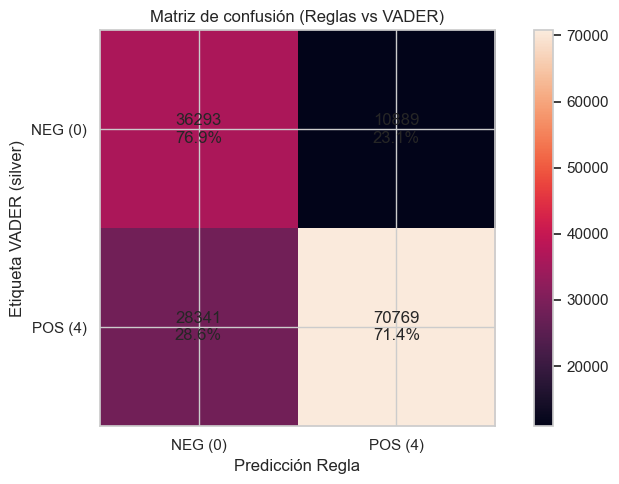

In [62]:
## 13. Matriz de confusión (Nuestro modelo vs VADER) — neutros descartados

mask = df["vader_label"].isin([0,4]) & df["sentiment_pred"].isin([0,4])
if mask.sum() == 0:
    print("⚠ No hay datos suficientes (VADER pos/neg) para matriz de confusión.")
else:
    y_true = (df.loc[mask, "vader_label"] == 4).astype(int).values  # 0/1
    y_pred = (df.loc[mask, "sentiment_pred"] == 4).astype(int).values

    TN = int(((y_true==0) & (y_pred==0)).sum())
    FP = int(((y_true==0) & (y_pred==1)).sum())
    FN = int(((y_true==1) & (y_pred==0)).sum())
    TP = int(((y_true==1) & (y_pred==1)).sum())
    cm = np.array([[TN, FP],[FN, TP]], dtype=int)

    df_counts = pd.DataFrame(
        cm, index=["Real NEG (VADER=0)","Real POS (VADER=4)"],
        columns=["Pred NEG (Reglas=0)","Pred POS (Reglas=4)"]
    )
    row_sums = df_counts.sum(axis=1).replace(0, np.nan)
    col_sums = df_counts.sum(axis=0).replace(0, np.nan)
    total = df_counts.values.sum()

    df_row_pct = (df_counts.div(row_sums, axis=0) * 100).round(2)
    df_col_pct = (df_counts.div(col_sums, axis=1) * 100).round(2)
    df_all_pct = (df_counts / total * 100).round(2) if total>0 else df_counts.astype(float)

    print("Conteos (absolutos):")
    display(df_counts)
    print("\nPorcentajes por FILA (≈ recall por clase VADER):")
    display(df_row_pct)
    print("\nPorcentajes por COLUMNA (≈ precision de nuestro modelo):")
    display(df_col_pct)
    print("\nPorcentajes sobre el TOTAL:")
    display(df_all_pct)

    # Heatmap simple con anotaciones (conteo + % por fila)
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title("Matriz de confusión (Reglas vs VADER)")
    plt.xlabel("Predicción Regla")
    plt.ylabel("Etiqueta VADER (silver)")
    plt.xticks([0,1], ["NEG (0)","POS (4)"])
    plt.yticks([0,1], ["NEG (0)","POS (4)"])

    for i in range(2):
        for j in range(2):
            val = cm[i, j]
            fila = cm[i, :].sum()
            pct_row = (val / fila * 100) if fila > 0 else 0.0
            plt.text(j, i, f"{val}\n{pct_row:.1f}%", ha="center", va="center")

    plt.colorbar()
    plt.tight_layout()
    plt.show()


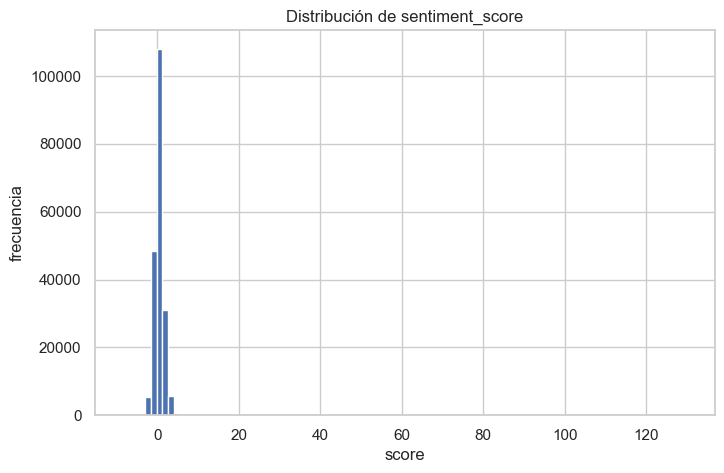

In [63]:
## 14. Gráfico de distribución de scores

plt.figure()
df["sentiment_score"].hist(bins=100)
plt.title("Distribución de sentiment_score")
plt.xlabel("score")
plt.ylabel("frecuencia")
plt.show()


In [64]:
## 15. Ejemplos donde el modelo se equivoca contra VADER (5 FP y 5 FN)
# - **FP**: VADER=0 (neg) y nuestro modelo=4 (pos)
# - **FN**: VADER=4 (pos) y nuestro modelo=0 (neg)
# Se priorizan los casos con mayor distancia al umbral.

if "sentiment_pred" not in df.columns or "sentiment_score" not in df.columns or "vader_label" not in df.columns:
    print("⚠ Faltan columnas. Ejecuta scoring y VADER antes.")
else:
    mask_fp = (df["vader_label"] == 0) & (df["sentiment_pred"] == 4)
    mask_fn = (df["vader_label"] == 4) & (df["sentiment_pred"] == 0)

    cols = ['clean_text', "sentiment_score", "sentiment_pred", "vader_label", "vader_compound"]
    ejemplos_fp = df.loc[mask_fp, cols].copy()
    ejemplos_fn = df.loc[mask_fn, cols].copy()

    umbral = float(globals().get("mejor_umbral", 0.0))
    ejemplos_fp["dist_umbral"] = (ejemplos_fp["sentiment_score"] - umbral).abs()
    ejemplos_fn["dist_umbral"] = (ejemplos_fn["sentiment_score"] - umbral).abs()

    top_fp = ejemplos_fp.sort_values("dist_umbral", ascending=False).head(5)
    top_fn = ejemplos_fn.sort_values("dist_umbral", ascending=False).head(5)

    print("──────────── FALSOS POSITIVOS (VADER NEG=0, Reglas POS=4) ────────────")
    for _, row in top_fp.iterrows():
        txt = str(row['clean_text']).replace("\n", " ")
        print(f"Texto: {txt[:200]}...")
        print(f"Score: {row['sentiment_score']:.3f} | VADER: NEG | Pred(Reglas): POS ✗  | compound={row['vader_compound']:.3f}\n")

    print("──────────── FALSOS NEGATIVOS (VADER POS=4, Reglas NEG=0) ────────────")
    for _, row in top_fn.iterrows():
        txt = str(row['clean_text']).replace("\n", " ")
        print(f"Texto: {txt[:200]}...")
        print(f"Score: {row['sentiment_score']:.3f} | VADER: POS | Pred(Reglas): NEG ✗  | compound={row['vader_compound']:.3f}\n")

    print("Tabla — 5 FALSOS POSITIVOS")
    display(top_fp.drop(columns=['dist_umbral']).reset_index(drop=True))

    print("Tabla — 5 FALSOS NEGATIVOS")
    display(top_fn.drop(columns=['dist_umbral']).reset_index(drop=True))


──────────── FALSOS POSITIVOS (VADER NEG=0, Reglas POS=4) ────────────
Texto: really really really really like would die meet hang outt come...
Score: 5.562 | VADER: NEG | Pred(Reglas): POS ✗  | compound=-0.209

Texto: get brownie amp bev evil evil evil kid say thank lol whew glad...
Score: 5.125 | VADER: NEG | Pred(Reglas): POS ✗  | compound=-0.784

Texto: bed listen kill hannah ill miss jonny least happy still make music ill get chance see hear...
Score: 4.750 | VADER: NEG | Pred(Reglas): POS ✗  | compound=-0.917

Texto: time ill ear look like beetroot think get ear get scafolde...
Score: 4.625 | VADER: NEG | Pred(Reglas): POS ✗  | compound=-0.077

Texto: ughhhh mad people make time like yucky thng cut deal stuf people tear kill...
Score: 4.263 | VADER: NEG | Pred(Reglas): POS ✗  | compound=-0.883

──────────── FALSOS NEGATIVOS (VADER POS=4, Reglas NEG=0) ────────────
Texto: really really really really really super tired want school...
Score: -7.119 | VADER: POS | Pred(Reglas): NEG ✗

,clean_text,sentiment_score,sentiment_pred,vader_label,vader_compound
0,really really really really like would die mee...,5.5625,4,0.0,-0.2092
1,get brownie amp bev evil evil evil kid say tha...,5.1250,4,0.0,-0.7845
2,bed listen kill hannah ill miss jonny least ha...,4.7500,4,0.0,-0.9169
3,time ill ear look like beetroot think get ear ...,4.6250,4,0.0,-0.0772
4,ughhhh mad people make time like yucky thng cu...,4.2625,4,0.0,-0.8834


Tabla — 5 FALSOS NEGATIVOS


,clean_text,sentiment_score,sentiment_pred,vader_label,vader_compound
0,really really really really really super tired...,-7.119141,0,4.0,0.4323
1,omg yes bum get kick shaun haha dannng must tr...,-4.262500,0,4.0,0.6808
2,lot hard research realise want stuff want need...,-3.500000,0,4.0,0.0516
3,load issue due lifehacker article back respons...,-3.500000,0,4.0,0.2960
4,sooooo miss brandon daft punk remind good bud ...,-3.300000,0,4.0,0.6369


In [66]:
## 16. Exportación a CSV
# Exporta columnas útiles sin depender de `target`.
cols_export = ['text', "clean_text", "sentiment_score", "sentiment_pred", "vader_label", "vader_compound"]
out_path = "resultados_sentimientos_v2_silver.csv"
df[cols_export].to_csv(out_path, index=False)
print(f"✓ Resultados exportados a: {out_path} (total={len(df):,})")


✓ Resultados exportados a: resultados_sentimientos_v2_silver.csv (total=200,000)
